In [ ]:
"""
Step 28: Integrating gene expression features for drug response prediction
Project: ML-based drug response biomarker discovery
"""


In [3]:
# Step 28.1 — Setup & imports

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import VarianceThreshold

from xgboost import XGBRegressor
import shap

import matplotlib.pyplot as plt

# Display settings
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 10)

print("Environment ready")


Environment ready


In [4]:
# Step 28.2 — Load Erlotinib response target (393 rows)

resp_path = "data/gdsc1_erlotinib_response.csv"
resp = pd.read_csv(resp_path)

print("Rows, Cols:", resp.shape)
print("Columns:", list(resp.columns))

# Quick checks
required_cols = ["CELL_LINE_NAME", "COSMIC_ID", "SANGER_MODEL_ID", "DRUG_NAME", "LN_IC50", "AUC", "Z_SCORE"]
missing = [c for c in required_cols if c not in resp.columns]
print("Missing required cols:", missing)

print("\nDRUG_NAME unique (top 10):", resp["DRUG_NAME"].dropna().unique()[:10])
print("LN_IC50 range:", (resp["LN_IC50"].min(), resp["LN_IC50"].max()))

# Ensure COSMIC_ID is numeric-like (for joining later)
resp["COSMIC_ID"] = pd.to_numeric(resp["COSMIC_ID"], errors="coerce")
print("COSMIC_ID nulls after coercion:", resp["COSMIC_ID"].isna().sum())

# Duplicates check
dup_cosmic = resp["COSMIC_ID"].duplicated().sum()
dup_cell = resp["CELL_LINE_NAME"].duplicated().sum()
print("Duplicate COSMIC_ID:", dup_cosmic)
print("Duplicate CELL_LINE_NAME:", dup_cell)

resp.head()


FileNotFoundError: [Errno 2] No such file or directory: 'data/gdsc1_erlotinib_response.csv'

In [5]:
# Step 28.2A — Check current working directory

import os
print(os.getcwd())


c:\Users\namal\OneDrive\Documents\ml-drug-response-biomarker-discovery\notebooks


In [6]:
# List files to locate the CSV

os.listdir(".")


['01_env_check.ipynb',
 '02_download_depmap_data.ipynb',
 '03_expression_features.ipynb']

In [8]:
import os

# Move from .../notebooks -> project root
os.chdir("..")

print("Now at:", os.getcwd())
print("Root contents:", os.listdir("."))


Now at: c:\Users\namal\OneDrive\Documents\ml-drug-response-biomarker-discovery
Root contents: ['.git', '.gitignore', 'data', 'environment.yml', 'notebooks', 'results']


In [9]:
# Step 28.2B — Load Erlotinib response target (from project root)

resp = pd.read_csv("data/gdsc1_erlotinib_response.csv")

print("Rows, Cols:", resp.shape)
print("Columns:", list(resp.columns))

# Required columns check
required_cols = [
    "CELL_LINE_NAME",
    "COSMIC_ID",
    "SANGER_MODEL_ID",
    "DRUG_NAME",
    "LN_IC50",
    "AUC",
    "Z_SCORE"
]

missing = [c for c in required_cols if c not in resp.columns]
print("Missing required cols:", missing)

# Basic sanity checks
print("\nDRUG_NAME unique:", resp["DRUG_NAME"].unique())
print("LN_IC50 range:", (resp["LN_IC50"].min(), resp["LN_IC50"].max()))

# Prepare COSMIC_ID for joins later
resp["COSMIC_ID"] = pd.to_numeric(resp["COSMIC_ID"], errors="coerce")
print("COSMIC_ID nulls after coercion:", resp["COSMIC_ID"].isna().sum())

print("Duplicate COSMIC_ID:", resp["COSMIC_ID"].duplicated().sum())
print("Duplicate CELL_LINE_NAME:", resp["CELL_LINE_NAME"].duplicated().sum())

resp.head()


Rows, Cols: (393, 9)
Columns: ['CELL_LINE_NAME', 'COSMIC_ID', 'SANGER_MODEL_ID', 'DRUG_NAME', 'LN_IC50', 'AUC', 'Z_SCORE', 'PUTATIVE_TARGET', 'PATHWAY_NAME']
Missing required cols: []

DRUG_NAME unique: <ArrowStringArray>
['Erlotinib']
Length: 1, dtype: str
LN_IC50 range: (np.float64(-3.130315), np.float64(5.293054))
COSMIC_ID nulls after coercion: 0
Duplicate COSMIC_ID: 0
Duplicate CELL_LINE_NAME: 0


,CELL_LINE_NAME,COSMIC_ID,SANGER_MODEL_ID,DRUG_NAME,LN_IC50,AUC,Z_SCORE,PUTATIVE_TARGET,PATHWAY_NAME
0,ES5,684057,SIDM00263,Erlotinib,3.966813,0.985678,1.299144,EGFR,EGFR signaling
1,ES7,684059,SIDM00269,Erlotinib,2.692090,0.972690,0.156076,EGFR,EGFR signaling
2,EW-11,684062,SIDM00203,Erlotinib,2.477990,0.944459,-0.035912,EGFR,EGFR signaling
3,SK-ES-1,684072,SIDM01111,Erlotinib,2.033564,0.950758,-0.434437,EGFR,EGFR signaling
4,COLO-829,687448,SIDM00909,Erlotinib,2.966007,0.954778,0.401702,EGFR,EGFR signaling


In [10]:
# Step 28.3 — Load DepMap sample mapping (for joins later)

map_path = "data/sample_info.csv"
sample_info = pd.read_csv(map_path)

print("Rows, Cols:", sample_info.shape)
print("Columns (subset):", sample_info.columns[:15].tolist())

# Keep only what we need
sample_map = sample_info[
    ["DepMap_ID", "CCLE_Name", "COSMIC_ID"]
].copy()

# Prepare COSMIC_ID to match response file
sample_map["COSMIC_ID"] = pd.to_numeric(sample_map["COSMIC_ID"], errors="coerce")

print("COSMIC_ID nulls in mapping:", sample_map["COSMIC_ID"].isna().sum())
sample_map.head()


FileNotFoundError: [Errno 2] No such file or directory: 'data/sample_info.csv'

In [11]:
import os
os.listdir("data")


['CCLE_expression.csv',
 'drug_response.csv',
 'expression.csv',
 'gdsc1_erlotinib_response.csv',
 'GDSC1_fitted_dose_response_27Oct23.xlsx',
 'gdsc_drug_response.csv',
 'README.md']

In [12]:
# Step 28.3C — Load DepMap sample_info.csv

import pandas as pd

sample_info = pd.read_csv("data/sample_info.csv")

print("Rows, Cols:", sample_info.shape)
print("Columns (first 15):", sample_info.columns[:15].tolist())

# Keep only required columns for joining
sample_map = sample_info[["DepMap_ID", "CCLE_Name", "COSMIC_ID"]].copy()

# Ensure COSMIC_ID matches response file type
sample_map["COSMIC_ID"] = pd.to_numeric(sample_map["COSMIC_ID"], errors="coerce")

print("COSMIC_ID nulls in mapping:", sample_map["COSMIC_ID"].isna().sum())

sample_map.head()


Rows, Cols: (1840, 29)
Columns (first 15): ['DepMap_ID', 'cell_line_name', 'stripped_cell_line_name', 'CCLE_Name', 'alias', 'COSMICID', 'sex', 'source', 'RRID', 'WTSI_Master_Cell_ID', 'sample_collection_site', 'primary_or_metastasis', 'primary_disease', 'Subtype', 'age']


KeyError: "['COSMIC_ID'] not in index"

In [13]:
# Step 28.3D — Fix COSMIC column name and rebuild mapping

# Rename COSMICID -> COSMIC_ID for consistency
sample_info = sample_info.rename(columns={"COSMICID": "COSMIC_ID"})

# Now select required columns
sample_map = sample_info[["DepMap_ID", "CCLE_Name", "COSMIC_ID"]].copy()

# Ensure COSMIC_ID is numeric
sample_map["COSMIC_ID"] = pd.to_numeric(sample_map["COSMIC_ID"], errors="coerce")

print("Mapping rows:", sample_map.shape)
print("COSMIC_ID nulls in mapping:", sample_map["COSMIC_ID"].isna().sum())

sample_map.head()


Mapping rows: (1840, 3)
COSMIC_ID nulls in mapping: 859


,DepMap_ID,CCLE_Name,COSMIC_ID
0,ACH-000016,SLR21_KIDNEY,NaN
1,ACH-000032,MHHCALL3_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN
2,ACH-000033,NCIH1819_LUNG,NaN
3,ACH-000043,HS895T_FIBROBLAST,NaN
4,ACH-000049,HEKTE_KIDNEY,NaN


In [14]:
# Step 28.4 — Merge Erlotinib response with DepMap mapping

merged = resp.merge(
    sample_map,
    on="COSMIC_ID",
    how="inner"
)

print("Merged rows:", merged.shape[0])
print("Unique COSMIC_ID after merge:", merged["COSMIC_ID"].nunique())
print("Unique DepMap_ID after merge:", merged["DepMap_ID"].nunique())

# What fraction survived?
print(f"Survival rate: {merged.shape[0] / resp.shape[0]:.2%}")

merged[["CELL_LINE_NAME", "COSMIC_ID", "DepMap_ID", "CCLE_Name"]].head()


Merged rows: 380
Unique COSMIC_ID after merge: 380
Unique DepMap_ID after merge: 380
Survival rate: 96.69%


,CELL_LINE_NAME,COSMIC_ID,DepMap_ID,CCLE_Name
0,ES5,684057,ACH-002106,ES5_BONE
1,ES7,684059,ACH-002108,ES7_BONE
2,EW-11,684062,ACH-002111,EW11_BONE
3,SK-ES-1,684072,ACH-000087,SKES1_BONE
4,COLO-829,687448,ACH-000644,COLO829_SKIN


In [15]:
# Step 28.5 — Load CCLE expression and subset to matched DepMap_IDs

expr_path = "data/CCLE_expression.csv"
expr = pd.read_csv(expr_path, index_col=0)

print("Raw expression shape (rows x cols):", expr.shape)
print("Example column names:", expr.columns[:5].tolist())

# DepMap IDs we need (380)
depmap_ids = merged["DepMap_ID"].tolist()

# Keep only columns present in expression
present_ids = [i for i in depmap_ids if i in expr.columns]
missing_ids = sorted(set(depmap_ids) - set(present_ids))

print("Matched DepMap_IDs present in expression:", len(present_ids))
print("Missing DepMap_IDs in expression:", len(missing_ids))
if len(missing_ids) > 0:
    print("First 10 missing:", missing_ids[:10])

# Subset and transpose to samples x genes
expr_sub = expr[present_ids].T
print("Expression subset shape (samples x genes):", expr_sub.shape)

# Align merged to the same sample order as expr_sub
merged_sub = merged.set_index("DepMap_ID").loc[present_ids].reset_index()

# Final check: rows align 1:1
print("Aligned merged_sub rows:", merged_sub.shape[0])
print("Aligned expr_sub rows:", expr_sub.shape[0])


EmptyDataError: No columns to parse from file

In [16]:
import os

path = "data/CCLE_expression.csv"
print("Exists:", os.path.exists(path))
print("Size (bytes):", os.path.getsize(path))

# Peek at the first ~300 characters
with open(path, "r", encoding="utf-8", errors="ignore") as f:
    head = f.read(300)

print("\nFIRST 300 CHARS:\n", head)


Exists: True
Size (bytes): 0

FIRST 300 CHARS:
 


In [17]:
import os

path = "data/CCLE_expression.csv"
print("Exists:", os.path.exists(path))
print("Size (MB):", round(os.path.getsize(path) / (1024*1024), 2))


Exists: True
Size (MB): 408.76


In [18]:
# Step 28.5D — Load CCLE expression and subset to matched DepMap_IDs

import pandas as pd

# Load expression (genes x DepMap_IDs)
expr = pd.read_csv("data/CCLE_expression.csv", index_col=0)

print("Raw expression shape (genes x samples):", expr.shape)
print("First 5 sample IDs:", expr.columns[:5].tolist())
print("First 5 genes:", expr.index[:5].tolist())

# DepMap IDs we want (from previous merge)
depmap_ids = merged["DepMap_ID"].tolist()

# Keep only DepMap IDs present in expression
present_ids = [i for i in depmap_ids if i in expr.columns]
missing_ids = sorted(set(depmap_ids) - set(present_ids))

print("Matched DepMap_IDs present in expression:", len(present_ids))
print("Missing DepMap_IDs:", len(missing_ids))

# Subset and transpose -> samples x genes
expr_sub = expr[present_ids].T
print("Expression subset shape (samples x genes):", expr_sub.shape)

# Align metadata rows to expression rows
merged_sub = merged.set_index("DepMap_ID").loc[present_ids].reset_index()

print("Aligned metadata rows:", merged_sub.shape[0])
print("Aligned expression rows:", expr_sub.shape[0])


Raw expression shape (genes x samples): (1406, 19221)
First 5 sample IDs: ['TSPAN6 (7105)', 'TNMD (64102)', 'DPM1 (8813)', 'SCYL3 (57147)', 'C1orf112 (55732)']
First 5 genes: ['ACH-001113', 'ACH-001289', 'ACH-001339', 'ACH-001538', 'ACH-000242']
Matched DepMap_IDs present in expression: 0
Missing DepMap_IDs: 380
Expression subset shape (samples x genes): (0, 1406)
Aligned metadata rows: 0
Aligned expression rows: 0


In [19]:
# Step 28.5E — Detect orientation and subset correctly

print("Does expr.index look like DepMap_IDs?", str(expr.index[0]).startswith("ACH-"))
print("Does expr.columns look like DepMap_IDs?", str(expr.columns[0]).startswith("ACH-"))

depmap_ids = merged["DepMap_ID"].tolist()

# DepMap IDs are in the ROWS (index)
present_ids = [i for i in depmap_ids if i in expr.index]
missing_ids = sorted(set(depmap_ids) - set(present_ids))

print("Matched DepMap_IDs present in expression (by index):", len(present_ids))
print("Missing DepMap_IDs:", len(missing_ids))
if missing_ids:
    print("First 10 missing:", missing_ids[:10])

# Subset -> samples x genes (already)
expr_sub = expr.loc[present_ids].copy()
print("Expression subset shape (samples x genes):", expr_sub.shape)

# Align metadata rows to expression rows
merged_sub = merged.set_index("DepMap_ID").loc[present_ids].reset_index()
print("Aligned metadata rows:", merged_sub.shape[0])
print("Aligned expression rows:", expr_sub.shape[0])

# quick peek
merged_sub[["DepMap_ID", "CELL_LINE_NAME", "COSMIC_ID", "CCLE_Name"]].head()


Does expr.index look like DepMap_IDs? True
Does expr.columns look like DepMap_IDs? False
Matched DepMap_IDs present in expression (by index): 236
Missing DepMap_IDs: 144
First 10 missing: ['ACH-000047', 'ACH-001023', 'ACH-001049', 'ACH-001064', 'ACH-001065', 'ACH-001081', 'ACH-001127', 'ACH-001131', 'ACH-001136', 'ACH-001138']
Expression subset shape (samples x genes): (236, 19221)
Aligned metadata rows: 236
Aligned expression rows: 236


,DepMap_ID,CELL_LINE_NAME,COSMIC_ID,CCLE_Name
0,ACH-000087,SK-ES-1,684072,SKES1_BONE
1,ACH-000644,COLO-829,687448,COLO829_SKIN
2,ACH-000137,8-MG-BA,687562,8MGBA_CENTRAL_NERVOUS_SYSTEM
3,ACH-000738,GB-1,687568,GB1_CENTRAL_NERVOUS_SYSTEM
4,ACH-000075,U-87-MG,687590,U87MG_CENTRAL_NERVOUS_SYSTEM


In [20]:
# Step 28.6 — Clean gene names and apply variance filtering

from sklearn.feature_selection import VarianceThreshold

# 1) Clean gene names: "TSPAN6 (7105)" -> "TSPAN6"
expr_sub.columns = (
    expr_sub.columns
    .str.replace(r"\s*\(.*\)", "", regex=True)
)

print("Example cleaned gene names:", expr_sub.columns[:5].tolist())

# 2) Variance filtering
# Threshold chosen to remove near-constant genes across 236 samples
vt = VarianceThreshold(threshold=0.5)
X_var = vt.fit_transform(expr_sub)

genes_kept = expr_sub.columns[vt.get_support()]

print("Original gene count:", expr_sub.shape[1])
print("Genes after variance filter:", len(genes_kept))
print("Filtered X shape (samples x genes):", X_var.shape)


Example cleaned gene names: ['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1orf112']
Original gene count: 19221
Genes after variance filter: 11299
Filtered X shape (samples x genes): (236, 11299)


In [21]:
# Step 28.7 — Train baseline expression-based model

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor

# Target
y = merged_sub["LN_IC50"].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_var, y, test_size=0.2, random_state=42
)

# Model
model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=42
)

# Fit
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Expression model R²:", round(r2, 3))
print("Expression model RMSE:", round(rmse, 3))


TypeError: got an unexpected keyword argument 'squared'

In [22]:
# Fix RMSE calculation for older sklearn versions
rmse = mean_squared_error(y_test, y_pred) ** 0.5

print("Expression model R²:", round(r2, 3))
print("Expression model RMSE:", round(rmse, 3))


Expression model R²: 0.214
Expression model RMSE: 0.807


SHAP values shape: (48, 11299)


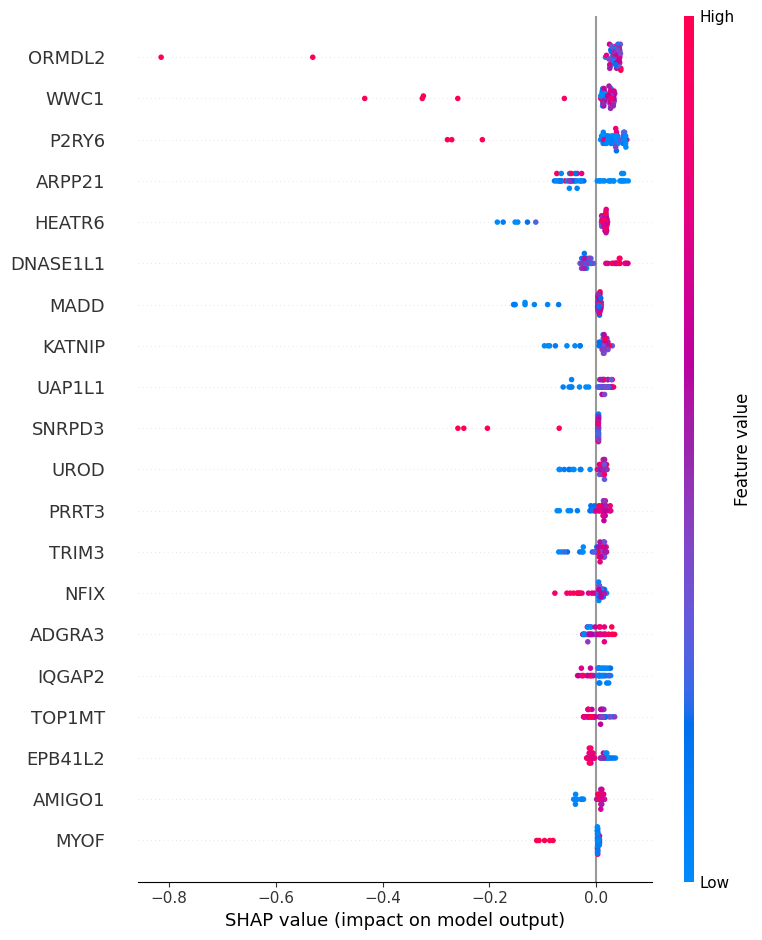

In [23]:
# Step 28.8 — SHAP analysis for expression-based model

import shap

# Use TreeExplainer (fast + correct for XGBoost)
explainer = shap.TreeExplainer(model)

# Compute SHAP values on test set only
shap_values = explainer.shap_values(X_test)

print("SHAP values shape:", shap_values.shape)

# Summary plot (global importance)
shap.summary_plot(
    shap_values,
    X_test,
    feature_names=genes_kept,
    max_display=20
)


In [24]:
# Step 28.9 — Directionality analysis for top SHAP genes

import numpy as np
import pandas as pd

# Mean SHAP value per gene (absolute importance ranking)
mean_abs_shap = np.abs(shap_values).mean(axis=0)

shap_df = pd.DataFrame({
    "Gene": genes_kept,
    "MeanAbsSHAP": mean_abs_shap
}).sort_values("MeanAbsSHAP", ascending=False)

top_genes = shap_df.head(20)["Gene"].tolist()

# Directionality: correlation between expression and SHAP value
directionality = []
for i, g in enumerate(top_genes):
    corr = np.corrcoef(expr_sub[g].loc[X_test.index], shap_values[:, genes_kept.get_loc(g)])[0,1]
    directionality.append(corr)

dir_df = pd.DataFrame({
    "Gene": top_genes,
    "MeanAbsSHAP": shap_df.head(20)["MeanAbsSHAP"].values,
    "Directionality": directionality
})

dir_df


AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [25]:
# Step 28.9A — Correct directionality analysis (fix index issue)

import numpy as np
import pandas as pd

# Recreate train/test split WITH indices
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_var,
    y,
    np.arange(X_var.shape[0]),
    test_size=0.2,
    random_state=42
)

# Mean absolute SHAP per gene
mean_abs_shap = np.abs(shap_values).mean(axis=0)

shap_df = pd.DataFrame({
    "Gene": genes_kept,
    "MeanAbsSHAP": mean_abs_shap
}).sort_values("MeanAbsSHAP", ascending=False)

top_genes = shap_df.head(20)["Gene"].tolist()

# Directionality: correlation between expression and SHAP value
directionality = []
for g in top_genes:
    gene_idx = genes_kept.get_loc(g)
    expr_vals = expr_sub.iloc[idx_test][g].values
    shap_vals = shap_values[:, gene_idx]
    corr = np.corrcoef(expr_vals, shap_vals)[0, 1]
    directionality.append(corr)

dir_df = pd.DataFrame({
    "Gene": top_genes,
    "MeanAbsSHAP": shap_df.head(20)["MeanAbsSHAP"].values,
    "Directionality": directionality
})

dir_df


,Gene,MeanAbsSHAP,Directionality
0,ORMDL2,0.062527,-0.434472
1,WWC1,0.048886,-0.503960
2,P2RY6,0.046981,-0.683695
3,ARPP21,0.043307,-0.420760
4,HEATR6,0.032942,0.705143
...,...,...,...
15,IQGAP2,0.014306,-0.815904
16,TOP1MT,0.013804,-0.683932
17,EPB41L2,0.013694,-0.858051
18,AMIGO1,0.013652,0.628811


In [26]:
import os

os.makedirs("results/expression_model", exist_ok=True)
os.makedirs("results/expression_model/plots", exist_ok=True)
os.makedirs("results/expression_model/tables", exist_ok=True)

print("Created:", os.listdir("results/expression_model"))


Created: ['plots', 'tables']


In [27]:
# Save dir_df (top 20 SHAP genes + directionality)
dir_df.to_csv("results/expression_model/tables/shap_top20_directionality.csv", index=False)

# Also save full SHAP importance ranking (all genes)
shap_df.to_csv("results/expression_model/tables/shap_importance_all_genes.csv", index=False)

print("Saved tables:",
      os.listdir("results/expression_model/tables"))


Saved tables: ['shap_importance_all_genes.csv', 'shap_top20_directionality.csv']


In [28]:
import matplotlib.pyplot as plt
import shap

plt.figure()
shap.summary_plot(
    shap_values, X_test,
    feature_names=genes_kept,
    max_display=20,
    show=False
)
plt.tight_layout()
plt.savefig("results/expression_model/plots/shap_summary_top20.png", dpi=300)
plt.close()

print("Saved plots:",
      os.listdir("results/expression_model/plots"))


Saved plots: ['shap_summary_top20.png']


In [29]:
# Re-save SHAP outputs to the correct repo path

import os
import matplotlib.pyplot as plt
import shap

# Make sure folders exist
os.makedirs("results/expression_model/plots", exist_ok=True)
os.makedirs("results/expression_model/tables", exist_ok=True)

# Save tables
dir_df.to_csv(
    "results/expression_model/tables/shap_top20_directionality.csv",
    index=False
)
shap_df.to_csv(
    "results/expression_model/tables/shap_importance_all_genes.csv",
    index=False
)

# Save SHAP plot
plt.figure()
shap.summary_plot(
    shap_values,
    X_test,
    feature_names=genes_kept,
    max_display=20,
    show=False
)
plt.tight_layout()
plt.savefig(
    "results/expression_model/plots/shap_summary_top20.png",
    dpi=300
)
plt.close()

print("Files saved.")


Files saved.
